# Analysis of dynamical polarizability of $C_6H_6$ in the linear response formalism

We analyze the computation of the dynamical polarizabilityi inside the linear response formalism.

The aim of this notebook is to:

* compute the Casida matrix associated to the highest value of virtual orbitals. 
* build the matrices associated to a lower number of virtual orbitals (by extracting its elements from the highest one) and discuss the rate of convergence of the statical polarizability to the reference value (formerly computed by including an explicit electric field). 
* evaluate the dynamical polarizability spectrum and discuss its stability

In [1]:
%autosave 0
from BigDFT import Logfiles as lf
from futile import Yaml
from futile.Utils import write
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0,'../../')
import Routine as R
outputpath = 'linear-response/'
import os
os.environ['BIGDFT_ROOT']='/bigdft/bin'

Autosave disabled


Define simulation setup, build default imput file and create link

In [ ]:
norb=15
box={7.0: {'nvirt':220},9.0: {'nvirt':220},10.0: {'nvirt':220}}

In [4]:
inp0 = {'dft' : 
        {'hgrids': 0.40,
         'gnrm_cv' : 1e-8,
         'itermax' : 100,
         'inputpsiid': 2},
        'tddft':{'tddft_approach': 'full'},
        'posinp': 'C6H6_posinp.xyz'}
Yaml.dump(inp0,outputpath + 'default.yaml')

import shutil
for rVal in box:
    dest='linear-response/log/data-Rmult_'+str(rVal)
    #shutil.rmtree(dest) #to be used if present
    link='../../virtual-orbitals/log/data-Rmult_'+str(rVal)
    %cd linear-response/log/
    !ln -s $link .
    %cd ../../

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/C6H6/free-bc/linear-response/log
ln: creazione del collegamento simbolico './data-Rmult_9.0' non riuscita: File già esistente
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/C6H6/free-bc
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/C6H6/free-bc/linear-response/log
ln: creazione del collegamento simbolico './data-Rmult_10.0' non riuscita: File già esistente
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/C6H6/free-bc
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/C6H6/free-bc/linear-response/log
ln: creazione del collegamento simbolico './data-Rmult_7.0' non riuscita: File già esistente
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/C6H6/free-bc


Run the simulations and read the results

In [5]:
reload(R)
for rVal,b in box.iteritems():
    R.write_input_for(b['nvirt'],rVal,outputpath)

input written in the file linear-response/Rmult_9.0_numVirt_220.yaml
input written in the file linear-response/Rmult_10.0_numVirt_220.yaml
input written in the file linear-response/Rmult_7.0_numVirt_220.yaml


In [6]:
def get_tddft_quantities(box,omp,mpi,outp,skip=True):
    from BigDFT import Calculators as C
    from futile.Utils import write
    for rVal in box:
        virtMax=box[rVal]['nvirt']
        code=C.SystemCalculator(omp=omp,mpi=mpi)
        %cd $outp
        code.run(name='Rmult_'+str(rVal)+'_numVirt_'+str(virtMax),skip=skip,outdir='./log/')
        dpath = './log/data-'+'Rmult_'+str(rVal)+'/transition_quantities.txt'
        trans = np.loadtxt(dpath)
        cpath = './log/data-'+'Rmult_'+str(rVal)+'/coupling_matrix.txt'
        Cmat = np.loadtxt(cpath)
        %cd ../
        box[rVal]['C']=Cmat
        write('Casida Matrix is symmetric',np.allclose(Cmat,Cmat.T,atol=1.e-12))
        box[rVal]['T']=trans

In [7]:
get_tddft_quantities(box,2,4,outputpath)

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/C6H6/free-bc/linear-response
Executing command:  mpirun -np 4 $BIGDFT_ROOT/bigdft -n Rmult_9.0_numVirt_220 -d ./log/ -s Yes
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/C6H6/free-bc
Casida Matrix is symmetric True
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/C6H6/free-bc/linear-response
Executing command:  mpirun -np 4 $BIGDFT_ROOT/bigdft -n Rmult_10.0_numVirt_220 -d ./log/ -s Yes
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/C6H6/free-bc
Casida Matrix is symmetric True
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/C6H6/free-bc/linear-response
Executing command:  mpirun -np 4 $BIGDFT_ROOT/bigdft -n Rmult_7.0_numVirt_220 -d ./log/ -s Yes
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/C6H6/free-bc
Casida Matrix is symmetric True


In [8]:
#update with logfile information
box[7.0]['logfilex']=lf.Logfile('virtual-orbitals/log/log-CR_Ex_rmult_7.0_numVirt_233.yaml')
box[7.0]['logfilez']=lf.Logfile('virtual-orbitals/log/log-CR_Ez_rmult_7.0_numVirt_233.yaml')
box[9.0]['logfilex']=lf.Logfile('virtual-orbitals/log/log-CR_Ex_rmult_9.0_numVirt_223.yaml')
box[9.0]['logfilez']=lf.Logfile('virtual-orbitals/log/log-CR_Ez_rmult_9.0_numVirt_223.yaml')
box[10.0]['logfilex']=lf.Logfile('virtual-orbitals/log/log-CR_Ex_rmult_10.0_numVirt_239.yaml')
box[10.0]['logfilez']=lf.Logfile('virtual-orbitals/log/log-CR_Ez_rmult_10.0_numVirt_239.yaml')

Define a list of virtual orbitals and the solve the eigenproblems

In [9]:
box[7.0].keys()

['logfilez', 'C', 'logfilex', 'T', 'nvirt']

In [30]:
reload(R)
#virtsmall = [16, 32, 48, 64, 80, 96, 112, 128, 160, 224]
virtsmall = [16,64,160]
for rVal,dict_box in box.iteritems():
    print 'Solve for rVal = ', rVal
    dict_tmp=R.solveEigenProblems(norb,dict_box,virtsmall+[dict_box['nvirt']])
    #dict_tmp=R.solveEigenProblems(norb,dict_box,virtsmall)
    dict_box['eigenproblems']=dict_tmp

Solve for rVal =  9.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 160
Eigensystem solved for 220
Solve for rVal =  10.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 160
Eigensystem solved for 220
Solve for rVal =  7.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 160
Eigensystem solved for 220


In [31]:
box[7.0]['eigenproblems'][16].keys()

['eigenvectors', 'eigenvalues', 'transitions', 'Cmat']

we gather the quantities relevant for the linear reponse calculation by adding keys to the box[rVal][eigenproblems][nalpha] dictionary

In [32]:
reload(R)
for rVal in box:
    dict_box=box[rVal]
    for nalpha in dict_box['eigenproblems']:
        dict_casida=dict_box['eigenproblems'][nalpha]
        R.gather_excitation_informations(dict_casida)

In [33]:
box[7.0]['eigenproblems'][16].keys()

['eigenvectors',
 'alpha_xyz',
 'oscillator_strengths',
 'Cmat',
 'eigenvalues',
 'transitions',
 'oscillator_strength_avg']

### Analysis of the statical polarizability

Plot the convergence of the statical polarizability in the various box

In [34]:
alpha = {}
for rVal in box:
    alpha[rVal] = {}
    nalpha = box[rVal]['eigenproblems'].keys()
    for na in nalpha:
        alpha[rVal][na] = box[rVal]['eigenproblems'][na]['alpha_xyz']

In [36]:
alphaX_ref = [83.856,83.856,45.620]
HaeV=27.21138386

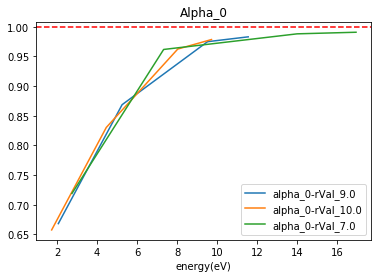

In [39]:
%matplotlib inline
alpha_ind = 0 #x,y,z
for rVal in alpha:
    alpha_plot = []
    eng = []
    nalpha = alpha[rVal].keys()
    nalpha.sort()
    for na in nalpha:
        alpha_plot.append(alpha[rVal][na][alpha_ind])
        eng.append(R.get_alpha_energy(box[rVal]['logfilex'],norb,na))
    alpha_plot = np.array(alpha_plot)/alphaX_ref[alpha_ind]
    eng = np.array(eng)*HaeV
    plt.plot(eng,alpha_plot,label='alpha_'+str(alpha_ind)+'-rVal_'+str(rVal))
plt.axhline(y=1.0, color='r', linestyle='--')
plt.title('Alpha_'+str(alpha_ind))
plt.legend(loc='best')
plt.xlabel('energy(eV)')
#plt.ylim(ymax=1.05)
plt.show()

### Analysis of the dynamical polarizability

In [43]:
reload(R)
sp = {}
for rVal in box:
    nalpha = box[rVal]['nvirt']
    f = box[rVal]['eigenproblems'][nalpha]['oscillator_strength_avg']
    e2 = box[rVal]['eigenproblems'][nalpha]['eigenvalues']
    sp[rVal] = R.get_spectrum(e2,f)

numpoint =  240  omegaMax (eV) =  32.7395929853
numpoint =  228  omegaMax (eV) =  31.0826343534
numpoint =  280  omegaMax (eV) =  38.1269227268


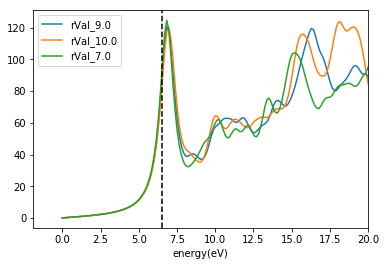

In [47]:
%matplotlib inline
for rVal in sp:
    plt.plot(sp[rVal]['omega'],sp[rVal]['imagPart'],label='rVal_'+str(rVal))
plt.xlim(xmax=20)
plt.legend(loc='best')
plt.xlabel('energy(eV)')
#plt.title('Absorption spectrum')
eps_h = abs(HaeV*R.get_alpha_energy(box[7.0]['logfilex'],norb,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.show()